![Semillero Astrofisica](../logo.PNG)

---
# Ecuaciones Diferenciales Ordinarias: Problema Inverso

Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver un problema inverso. Es decir, no solo queremos resolver la ecuación diferencial sino que también queremos descubrir parámetros de la ecuación. Para esto vamos a utilizar una solución de referencia y la ecuación del péndulo. Nuestras incógnitas serán el ángulo y la frecuencia angular.

\begin{equation}
    \ddot{\theta}+\omega^2\sin{\theta}=0
\end{equation}

con 

\begin{equation}
    \omega^2=\frac{g}{L}
\end{equation}

Las condiciones iniciales serán 

\begin{equation}
    \theta_0=\frac{\pi}{2}, \qquad \dot{\theta_0}=0
\end{equation}

In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()
tf.keras.backend.set_floatx('float64')

Using backend: tensorflow.compat.v1

2022-10-20 22:19:51.693119: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 22:19:51.696683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 22:19:51.696701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2022-10-20 22:19:52.868847: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-20 22:19:52.868888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## Construir la Solución de Referencia

Necesitamos algunos datos, como si fueran medidas experimentales. Para simular esto, vamos a resolver la ecuación diferencial con odeint https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html y luego le vamos a sumar un ruido aleatorio a la solución para usarla luego en la red neuronal. 

Como es usual para resolver ecuaciones de segundo orden, hacemos la sustitución

\begin{equation}
    \begin{split}
        &\dot{\theta}=\zeta \\
        &\dot{\zeta}=-\omega^2\sin{\theta} \\
    \end{split}
\end{equation}

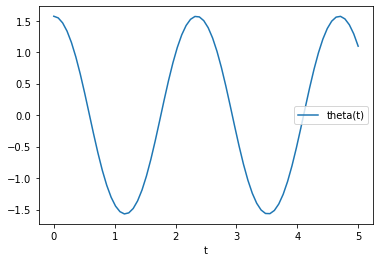

In [2]:
from scipy.integrate import odeint
g=10
L=1

def model(y,t):
    θ, ζ = y
    dθ = ζ
    dζ = -(g/L)*np.sin(θ)
    return [dθ, dζ]

# time points
time = np.linspace(0, 5, 70)

# solve ODE
y0 = [np.pi/2, 0.0]
sol = odeint(model,y0,time)

# Reacomodar los arrays para más tarde
time = time.reshape(len(time),1)
sol = sol[:, 0].reshape(len(time),1)

plt.plot(time, sol, label='theta(t)')
plt.legend(loc='right')
plt.xlabel('t')
plt.show()

## 1. Definir la Ecuación a Resolver

~~~python
deepxde.backend.backend.Variable(initial_value, dtype=None)
~~~

In [3]:
w2 = dde.Variable(20.0,'float64') # Variable para ajustar

def ODE(t, y):
    d2y_dt2 = dde.grad.hessian(y, t)
    s = tf.math.sin(y)
    return d2y_dt2 + w2*s

## 2. Definir Dominio de la Ecuación


In [4]:
geom = dde.geometry.TimeDomain(0, 5)

## 3. Definir Condiciones Iniciales y de Frontera

~~~python
class deepxde.icbc.boundary_conditions.OperatorBC(geom, 
                                                  func, 
                                                  on_boundary)
~~~

General operator boundary conditions: func(inputs, outputs, X) = 0. 

- **func:** A function takes arguments (inputs, outputs, X) and outputs a tensor of size N x 1, where N is the length of inputs. inputs and outputs are the network input and output tensors, respectively; X are the NumPy array of the inputs.

Ver detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html?highlight=boundary_conditions.OperatorBC#deepxde.icbc.boundary_conditions.OperatorBC

In [5]:
def in_bdr(_, on_initial):
    return on_initial

def IC_1(inputs):
    return np.pi/2

def IC_2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs) # = 0 #se define igual que la ecuación

IC1 = dde.icbc.IC(        geom, IC_1, in_bdr)
IC2 = dde.icbc.OperatorBC(geom, IC_2, in_bdr)

## 4. Añadir Datos Experimentales

~~~python
class deepxde.icbc.boundary_conditions.PointSetBC(points, 
                                                  values, 
                                                  component=0, 
                                                  batch_size=None, 
                                                  shuffle=True)
~~~

Documentación en https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html?highlight=icbc.PointSetBC#deepxde.icbc.boundary_conditions.PointSetBC

Los datos extra se tratan como condiciones iniciales o de frontera.

In [6]:
exp_data = dde.icbc.PointSetBC(time, sol)

## 5. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.pde.TimePDE(geometryxtime, 
                               pde, 
                               ic_bcs, 
                               num_domain=0, 
                               num_boundary=0, 
                               num_initial=0, 
                               train_distribution='Hammersley', 
                               anchors=None, 
                               exclusions=None, 
                               solution=None, 
                               num_test=None, 
                               auxiliary_var_function=None
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TimePDE#deepxde.data.pde.TimePDE. 

In [7]:
data = dde.data.PDE(geom, ODE, [IC1, IC2, exp_data], 126, 8, num_test=100,
                    train_distribution='uniform', anchors=time)

## 6. Crear la Red Neuronal


In [8]:
layer_size = [1] + [30]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## 7. Compilar y Entrenar el Modelo


In [9]:
# Modelo
model = dde.Model(data, net)
variable = dde.callbacks.VariableValue([w2], period=1000)

# Optimizador Adam para ajustar el valor de w^2
model.compile("adam", lr=1e-3, external_trainable_variables=[w2])
loss_history, train_state = model.train(iterations=14000, callbacks=[variable])

# Optimizador L-BFGS para ajustar la ecuación diferencial (no ajusta w^2)
dde.optimizers.config.set_LBFGS_options(maxiter=10000)
model.compile("L-BFGS", external_trainable_variables=w2)
losshistory, train_state = model.train(callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.037304 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-20 22:19:54.427898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.255713 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.74e+01, 2.47e+00, 2.00e-02, 1.68e+00]    [7.65e+01, 2.47e+00, 2.00e-02, 1.68e+00]    []  
0 [2.00e+01]


2022-10-20 22:19:54.650785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [8.48e-02, 2.29e+00, 5.16e-03, 1.31e+00]    [5.80e-02, 2.29e+00, 5.16e-03, 1.31e+00]    []  
1000 [2.00e+01]
2000      [1.08e-01, 2.22e+00, 6.48e-03, 1.30e+00]    [7.84e-02, 2.22e+00, 6.48e-03, 1.30e+00]    []  
2000 [1.99e+01]
3000      [2.56e-01, 1.89e+00, 4.79e-04, 1.28e+00]    [2.52e-01, 1.89e+00, 4.79e-04, 1.28e+00]    []  
3000 [1.97e+01]
4000      [3.04e-01, 1.81e+00, 2.73e-04, 1.27e+00]    [3.11e-01, 1.81e+00, 2.73e-04, 1.27e+00]    []  
4000 [1.93e+01]
5000      [3.35e-01, 1.74e+00, 3.57e-04, 1.26e+00]    [3.45e-01, 1.74e+00, 3.57e-04, 1.26e+00]    []  
5000 [1.86e+01]
6000      [3.69e-01, 1.66e+00, 3.89e-04, 1.25e+00]    [3.79e-01, 1.66e+00, 3.89e-04, 1.25e+00]    []  
6000 [1.76e+01]
7000      [4.58e-01, 1.41e+00, 6.30e-04, 1.23e+00]    [4.74e-01, 1.41e+00, 6.30e-04, 1.23e+00]    []  
7000 [1.65e+01]
8000      [6.16e-01, 1.02e+00, 3.60e-03, 1.21e+00]    [6.47e-01, 1.02e+00, 3.60e-03, 1.21e+00]    []  
8000 [1.51e+01]
9000      [6.81e-01, 8.28e-01, 5.46e-03, 1.16e+0

## 7. Visualizar la Solución

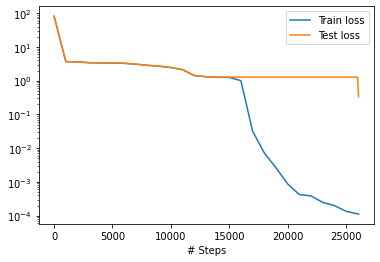

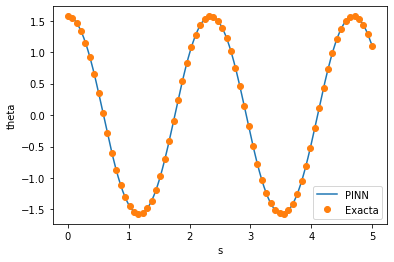

Expected w^2 Value:  10.0
w^2 Value:  [11.032551031572838]
Error:  10.325510315728383  %


In [10]:
dde.utils.external.plot_loss_history(losshistory)

t = geom.uniform_points(1000)
y = model.predict(t)

plt.figure()
plt.plot(t,y,label="PINN")
plt.plot(time,sol,'o',label="Exacta")
plt.xlabel('s')
plt.ylabel('theta')
plt.legend()
plt.show()

print('Expected w^2 Value: ', g/L)
print('w^2 Value: ', variable.get_value())
print('Error: ', 100*abs((g/L)-variable.get_value()[0])/(g/L), ' %')